In [12]:
hiapp = ['2021-03-03_IAPP_2n5_sliceA_0V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_10V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_20V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_30V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_40V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_50V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_60V_dt_extracted.txt', '2021-03-03_IAPP_2n5_sliceA_70V_dt_extracted.txt']
XData = []
YData = []

for filename in hiapp:
    filenameparts = filename.split('_')
    voltage = filenameparts[4].replace('V', '')
    voltage = int(voltage)
    arrtime = []
    intensity = []
    xdata = []
    ydata = []
    with open (filename, 'r') as f:
        for dataline in f:
            dataline = dataline.replace('\n', '')
            arrtime_intensity = dataline.split('\t')
            arrtime.append(float(arrtime_intensity[0]))
            intensity.append(int(arrtime_intensity[1]))
    for index, intensity_value in enumerate(intensity):
        if intensity_value > 1.0:
            #n = int(10.0 * np.log2(intensity_value))
            n = int(intensity_value/100.)
            xdata += [arrtime[index]]*n
    
    ydata = [voltage]*len(xdata)
    #print(len(xdata))
    #print(len(ydata))
    XData.extend(xdata)
    YData.extend(ydata)
    arrtime = []
    intensity = []
    xdata = []
    ydata = []
    
print(len(XData))
print(len(YData))

92570
92570


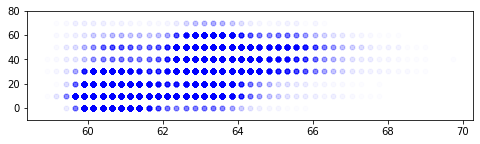

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GM

XArr = np.array(XData)
YArr = np.array(YData)

YArrDiv = YArr/100
XYArrDiv = np.column_stack((XArr,YArr))

fig, ax = plt.subplots()
fig.set_size_inches(8,2)
ax.set_ylim([-10,80])
ax.scatter(XArr, YArr, c='blue', s=25, alpha=0.01)
#plt.show()

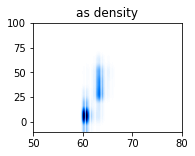

In [56]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.mixture import GaussianMixture

n_contours = 16
density_colormap = LinearSegmentedColormap.from_list(name='density', colors=['#FFFFFF','#0080FF','#000080','#000000'], N=256)
contour_colormap = LinearSegmentedColormap.from_list(name='contour', colors=['#B0B0B0','#0080FF'], N=n_contours)

x_range = (50, 80)
y_range = (-10, 100)

n_grid = 30
# Fake this for now
#hist, x_edges, y_edges = test_data_density = np.histogram2d(x_vals_merge, y_vals_merge, bins=(n_grid,n_grid), range=[x_range, y_range])
hist, x_edges, y_edges = test_data_density = np.histogram2d(XYArrDiv[:, 0], XYArrDiv[:, 1], bins=(n_grid*5,10), range=[x_range, y_range])

#H = hist.T
input_density = hist.T

fig, ax = plt.subplots(1, 1) # rows, cols
fig.set_size_inches(8,2)

ax.set_title('as density')
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.imshow(input_density, cmap=density_colormap, origin='lower', extent=x_range + y_range, aspect=0.2) 

plt.show()

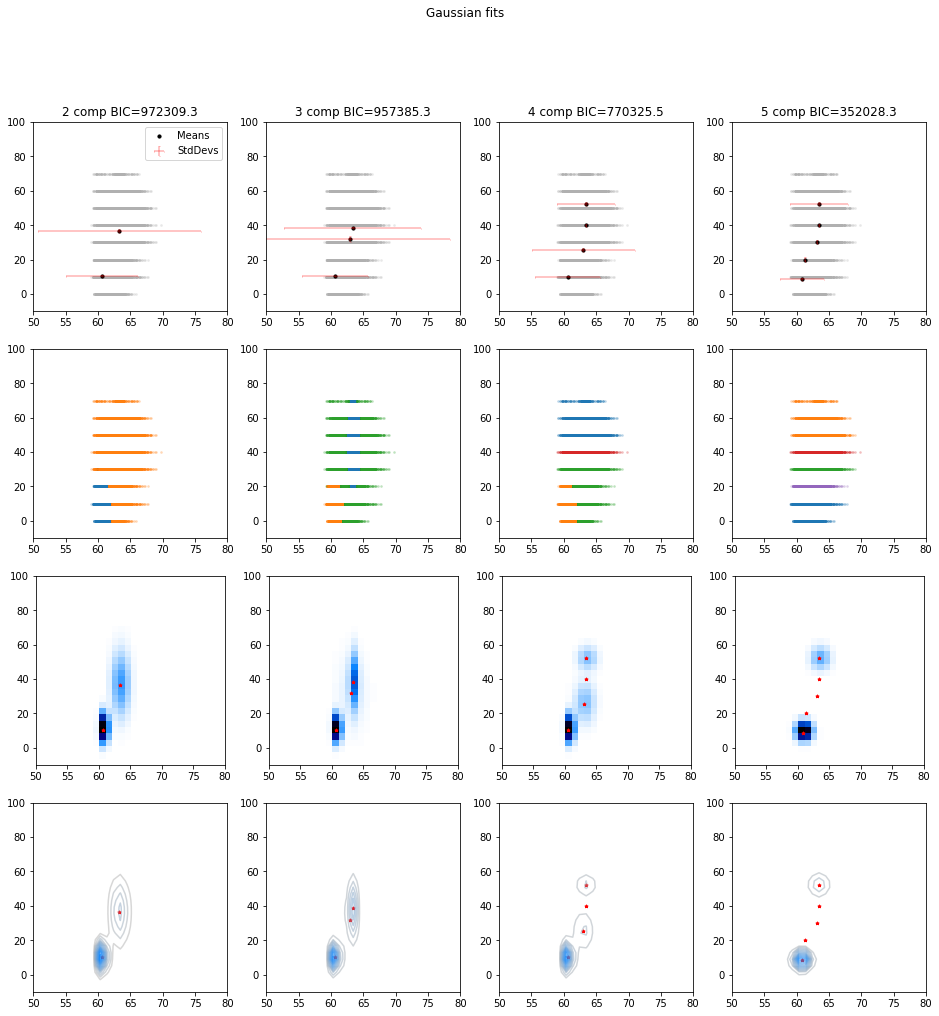

In [59]:
test_n_components = [2,3,4,5]

fig2, axarr = plt.subplots(4, len(test_n_components))
fig2.suptitle('Gaussian fits')
fig2.set_size_inches(16,16)
                   
best_bic = float('inf')
best_gmm = None

for i, n_comp in enumerate(test_n_components):
    ax1 = axarr[0,i] # First fig row
    ax1.set_xlim(x_range)
    ax1.set_ylim(y_range)
  
    gmm = GaussianMixture(n_components=n_comp, covariance_type='diag')
    gmm.fit(XYArrDiv)

    bic = gmm.bic(XYArrDiv) # For evaluating best n_comp

    x_vals_mean = gmm.means_[:,0]
    y_vals_mean = gmm.means_[:,1]

    # Sqrt for Var to Std
    x_vals_std = np.sqrt(gmm.covariances_[:,0]) # ,0]) # x to x variance from covar mat
    y_vals_std = np.sqrt(gmm.covariances_[:,1]) # ,1]) # y to y variance from covar mat

    ax1.scatter(XYArrDiv[:, 0], XYArrDiv[:, 1], s=3, alpha=0.2, c='#B0B0B0')

    ax1.errorbar(x_vals_mean, y_vals_mean, x_vals_std, y_vals_std, fmt='none',
               color='red',alpha=0.3,  label='StdDevs', capsize=0.5)

    ax1.scatter(x_vals_mean, y_vals_mean, s=10, c='black', marker='o', label='Means')


    ax1.set_title(f'{n_comp} comp BIC={bic:.1f}')

    if i == 0:
        ax1.legend()

    # Component predition of _original_ points 

    ax2 = axarr[1,i] # Second fig row
    ax2.set_xlim(x_range)
    ax2.set_ylim(y_range)

    labels = gmm.predict(XYArrDiv)

    for j in range(n_comp):
        selection = labels == j # Bool array: True where labels are this comp (j)
        ax2.scatter(XYArrDiv[selection, 0], XYArrDiv[selection, 1], s=3, alpha=0.2)

    # Density estimation of a grid of points
    x1, x2 = x_range
    y1, y2 = y_range
    aspect = (x2-x1)/(y2-y1)
    
    x_points = np.linspace(x1, x2, n_grid) # Axis points
    y_points = np.linspace(y1, y2, n_grid)

    x_grid, y_grid = np.meshgrid(x_points, y_points) # n_grid , n_grid of coordinates
    x_grid_flat = x_grid.ravel()  # Flatten to list
    y_grid_flat = y_grid.ravel() 
    stacked_points = np.array([x_grid_flat, y_grid_flat]).T # to get x,y pairs

    density = gmm.score_samples(stacked_points) # comes as log probabilties
    density = np.exp(density) # Real probs
    density_2d = density.reshape([n_grid, n_grid]) # Restore points grid (of heights)

    ax3 = axarr[2,i] # third fig row
    ax3.set_xlim(x_range)
    ax3.set_ylim(y_range)
    ax3.imshow(density_2d, cmap=density_colormap, origin='lower', extent=x_range + y_range, aspect=aspect) 
    ax3.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')

    ax4 = axarr[3,i]
    ax4.contour(x_grid, y_grid, density_2d, levels=n_contours, alpha=0.5, cmap=contour_colormap)
    ax4.scatter(x_vals_mean, y_vals_mean, s=10, c='red', marker='*', label='Means')

    #ax5 = axarr[4,i]

    ## Equalise reconstructed scale to input scale
    #density_2d *= input_density.sum()/density_2d.sum()

    #diff = input_density - density_2d
    #maxd = 40 # Set by inspection; same scale for all plots

    #rms = np.sqrt(np.mean(diff*diff))

    #ax5.set_title(f'Residual RMS = {rms:.3}')
    #ax5.set_xlim(x_range)
    #ax5.set_ylim(y_range)
    #ax5.imshow(diff, cmap='coolwarm', vmin=-maxd, vmax=maxd, origin='lower', extent=x_range + y_range)


plt.show()